In [2]:
import pandas as pd
import numpy as np
from numpy import savetxt
from tqdm import tqdm, tqdm_notebook
from sklearn.preprocessing import StandardScaler
pd.set_option('display.max_columns', None)
import sys
import itertools

In [3]:
pip install econml

     |████████████████████████████████| 3.3 MB 4.2 MB/s 
     |████████████████████████████████| 356 kB 48.5 MB/s 
     |████████████████████████████████| 123 kB 42.0 MB/s 
     |████████████████████████████████| 77 kB 3.1 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491648 sha256=633aac12dc4818a388e563f14e4f2d6f957e86c46819ff865cd89fd61ca95720
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap
  Attempting uninstall: pydot
    Found existing installation: pydot 1.3.0
    Uninstalling pydot-1.3.0:
      Successfully uninstalled pydot-1.3.0


In [4]:
import econml
import warnings
#warnings.filterwarnings('ignore')

In [5]:
# Main imports
from econml.ortho_forest import DMLOrthoForest, DROrthoForest, DiscreteTreatmentOrthoForest
from econml.sklearn_extensions.linear_model import WeightedLassoCVWrapper, WeightedLasso, WeightedLassoCV

from econml.cate_interpreter import SingleTreeCateInterpreter, SingleTreePolicyInterpreter
import graphviz

# Helper imports
import numpy as np
from itertools import product
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression, LogisticRegressionCV
import matplotlib.pyplot as plt

%matplotlib inline

# A few more imports
import os
import pandas as pd
import urllib.request
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import Lasso, LassoCV, LinearRegression, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
case_id_col = "Case ID"
activity_col = "Activity"
resource_col = "org:resource"
timestamp_col = "time:timestamp"

treatment = 'treatment'
outcome = 'duration'

In [7]:
dynamic_cat_cols = ['Activity', 'org:resource']
static_cat_cols = ['(case)_Item_Type', '(case)_Spend_area_text', '(case)_Sub_spend_area_text', '(case)_Vendor',
                   '(case)_GR-Based_Inv__Verif_', '(case)_Spend_classification_text', '(case)_Item_Category', '(case)_Company',
                   '(case)_Name', '(case)_Document_Type']
dynamic_num_cols = ['Cumulative_net_worth_(EUR)', 'open_cases', 'month', 'weekday', 'hour', 'timesincelastevent', 'timesincecasestart']
static_num_cols = ['timesincefirstcase', '(case)_Item', 'duration', 'treatment']

cat_cols = dynamic_cat_cols + static_cat_cols
num_cols = dynamic_num_cols + static_num_cols

In [8]:
tqdm.pandas()

In [9]:
# Connect with Google Drive
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [10]:
df2 =pd.read_csv('gdrive/My Drive/Data/data_bpic19_readyToUse.csv')
df2['treatment'] = df2[treatment].replace({0:1, 1:0})

In [11]:
# Define some parameters
N_trees = [200]
Min_leaf_size = [10]
Max_depth = [10]
Subsample_ratio = [0.7]
Lambda_reg= [0.01]

In [12]:
# preparing the data 
train, valid = train_test_split(df2, test_size=0.2, shuffle=False)
train, test = train_test_split(train, test_size=0.2, shuffle=False)
features = train.drop([outcome, treatment], axis=1)
features_test = test.drop([outcome, treatment], axis=1)


cat_confound_cols = ['(case)_Item_Type',  '(case)_Spend_area_text', '(case)_Sub_spend_area_text',
                     '(case)_Vendor', '(case)_GR-Based_Inv__Verif_', '(case)_Spend_classification_text',
                     '(case)_Item_Category','(case)_Name', '(case)_Company', '(case)_Document_Type', '(case)_Item']
num_confound_cols = features.columns.difference(cat_confound_cols)


cat_hetero_cols = ['(case)_Item_Type', '(case)_Spend_area_text', '(case)_Sub_spend_area_text',
                   '(case)_Vendor', '(case)_GR-Based_Inv__Verif_', '(case)_Spend_classification_text',
                   '(case)_Item_Category', '(case)_Name', '(case)_Company', '(case)_Document_Type', '(case)_Item']
num_hetero_cols = features.columns.difference(cat_hetero_cols)
#num_hetero_cols = ['Cumulative_net_worth_(EUR)']

Y = train[outcome].to_numpy()
T = train[treatment].to_numpy()
scaler = StandardScaler()
W1 = scaler.fit_transform(features[[c for c in num_confound_cols]].to_numpy())
W2 = pd.get_dummies(features[cat_confound_cols]).to_numpy()
W = np.concatenate([W1, W2], axis=1)
X1 = scaler.fit_transform(features[[c for c in num_hetero_cols]].to_numpy())
X2 = pd.get_dummies(features[cat_hetero_cols]).to_numpy()
X = np.concatenate([X1, X2], axis=1)

X1_test = scaler.fit_transform(features_test[[c for c in num_hetero_cols]].to_numpy())
X2_test = pd.get_dummies(features_test[cat_hetero_cols]).to_numpy()
X_test = np.concatenate([X1_test, X2_test], axis=1)

tmp = pd.DataFrame(X)
tmp2 = pd.DataFrame(X_test)

# Get missing columns in the training test
missing_cols = set( tmp.columns ) - set( tmp2.columns )
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    tmp2[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
tmp2 = tmp2[tmp.columns]

X_test = tmp2.to_numpy()

(200, 10, 10, 0.7, 0.01)


The econml.ortho_forest.DMLOrthoForest class has been moved to econml.orf.DMLOrthoForest; an upcoming release will remove support for the old name
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 26.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 25.1min finished
Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]:

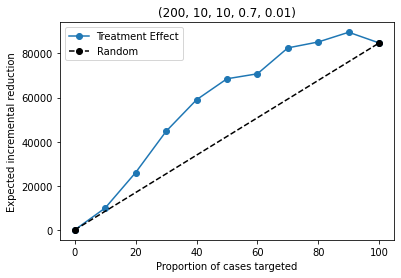

In [13]:
# curve for the test set
for i in itertools.product(N_trees, Min_leaf_size, Max_depth, Subsample_ratio, Lambda_reg):
    print(i)
    n_trees = i[0]
    min_leaf_size = i[1]
    max_depth = i[2]
    subsample_ratio = i[3]
    lambda_reg = i[4]
    est = DMLOrthoForest(
        n_trees=n_trees, min_leaf_size=min_leaf_size, max_depth=max_depth, 
        subsample_ratio=subsample_ratio, discrete_treatment=True,
        model_T=LogisticRegression(C=1/(X.shape[0]*lambda_reg), penalty='l1', solver='saga'),
        model_Y=Lasso(alpha=lambda_reg),
        model_T_final=LogisticRegression(C=1/(X.shape[0]*lambda_reg), penalty='l1', solver='saga'), 
        model_Y_final=WeightedLasso(alpha=lambda_reg),
        random_state=200
       )
    
    ortho_model = est.fit(Y, T, X=X, W=W)
    batches = np.array_split(X_test, X_test.shape[0] / 100)
    treatment_effects = est.const_marginal_effect(batches[0])
    ii = 0
    for batch in batches[1:]:
#         print(ii)
        estimates = est.const_marginal_effect(batch)
        treatment_effects = np.append(treatment_effects, estimates)
        ii += 1
    df_results = test
    df_results['Treatment Effects'] = treatment_effects
    
#     Calculate default (90%) confidence intervals for the default treatment points T0=0 and T1=1
#     te_lower, te_upper = est.effect_interval(batches[0])
#     ii = 0
#     for batch in batches[1:]:
#         print(ii)
#         lower, upper = est.effect_interval(batch)
#         te_lower = np.append(te_lower, lower)
#         te_upper = np.append(te_upper, upper)
#         ii += 1
        
#     df_results['te_lower'] = te_lower
#     df_results['te_upper'] = te_upper
#     df_results['Interval Length'] = df_results['te_upper'] - df_results['te_lower']
    
    net_value = [0]
    net_value2 = [0]
    net_value3 = [0]

    percentages = [10,20,30,40,50,60,70,80,90,100]

    for n in percentages:
        num = int(len(df_results)*(n/100))
        top_n = df_results.nsmallest(num,'Treatment Effects')
        n_treated = top_n[top_n['treatment']==1].shape[0]
        n_control = top_n[top_n['treatment']==0].shape[0]
        scale_factor = n_treated/n_control

        treated = top_n[top_n['treatment']==1]['duration'].sum()
        control = top_n[top_n['treatment']==0]['duration'].sum()

        reduction = (scale_factor*control) - treated 
        net_value.append(reduction)
        
#     for n in percentages:
#         num = int(len(df_results)*(n/100))
#         top_n = df_results.nsmallest(num,'te_lower')
#         n_treated = top_n[top_n['treatment']==1].shape[0]
#         n_control = top_n[top_n['treatment']==0].shape[0]
#         scale_factor = n_treated/n_control

#         treated = top_n[top_n['treatment']==1]['duration'].sum()
#         control = top_n[top_n['treatment']==0]['duration'].sum()

#         reduction = (scale_factor*control) - treated 
#         net_value2.append(reduction)
        
#     for n in percentages:
#         num = int(len(df_results)*(n/100))
#         top_n = df_results.nsmallest(num,'te_upper')
#         n_treated = top_n[top_n['treatment']==1].shape[0]
#         n_control = top_n[top_n['treatment']==0].shape[0]
#         scale_factor = n_treated/n_control

#         treated = top_n[top_n['treatment']==1]['duration'].sum()
#         control = top_n[top_n['treatment']==0]['duration'].sum()

#         reduction = (scale_factor*control) - treated 
#         net_value3.append(reduction)

    plt.plot([0]+percentages, net_value, label="Treatment Effect", marker="o")
#     plt.plot([0]+percentages, net_value2, label="TE Lower bound", marker="o", color='Green')
#     plt.plot([0]+percentages, net_value3, label="TE Upper bound", marker="o", color='Red')
    plt.plot([0,percentages[9]], [0,net_value[10]], label="Random",  marker="o", color='Black',
             linestyle='dashed')
    plt.xlabel('Proportion of cases targeted')
    plt.ylabel('Expected incremental reduction')
    plt.legend(loc='best')
    plt.title(i)

    plt.savefig('gdrive/My Drive/Results/Qini_curve_BPIC19_%s.png'%str(i), format='png', dpi=300)

In [17]:
df_results.to_csv('gdrive/My Drive/Results/dataframe_with_results_BPIC19', index=False)

In [18]:
# Data prep for running baseline
train = train[train[treatment]==0]
features = train.drop([outcome, treatment, case_id_col], axis=1)
features_test = test.drop([outcome, treatment], axis=1)

cat_confound_cols = ['(case)_Item_Type',  '(case)_Spend_area_text', '(case)_Sub_spend_area_text',
                     '(case)_Vendor', '(case)_GR-Based_Inv__Verif_', '(case)_Spend_classification_text',
                     '(case)_Item_Category','(case)_Name', '(case)_Company', '(case)_Document_Type', '(case)_Item']
num_confound_cols = features.columns.difference(cat_confound_cols)


cat_hetero_cols = ['(case)_Item_Type', '(case)_Spend_area_text', '(case)_Sub_spend_area_text',
                   '(case)_Vendor', '(case)_GR-Based_Inv__Verif_', '(case)_Spend_classification_text',
                   '(case)_Item_Category', '(case)_Name', '(case)_Company', '(case)_Document_Type', '(case)_Item']
num_hetero_cols = features.columns.difference(cat_hetero_cols)
#num_hetero_cols = ['Cumulative_net_worth_(EUR)']

Y = train[outcome].to_numpy()
T = train[treatment].to_numpy()
scaler = StandardScaler()

X1 = scaler.fit_transform(features[[c for c in num_hetero_cols]].to_numpy())
X2 = pd.get_dummies(features[cat_hetero_cols]).to_numpy()
X = np.concatenate([X1, X2], axis=1)

X1_test = scaler.fit_transform(features_test[[c for c in num_hetero_cols]].to_numpy())
X2_test = pd.get_dummies(features_test[cat_hetero_cols]).to_numpy()
X_test = np.concatenate([X1_test, X2_test], axis=1)

tmp = pd.DataFrame(X)
tmp2 = pd.DataFrame(X_test)

# Get missing columns in the training test
missing_cols = set( tmp.columns ) - set( tmp2.columns )
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    tmp2[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
tmp2 = tmp2[tmp.columns]

X_test = tmp2.to_numpy()

MAE of test: 129.8847842141311
MAE of test: 124.92528100125254


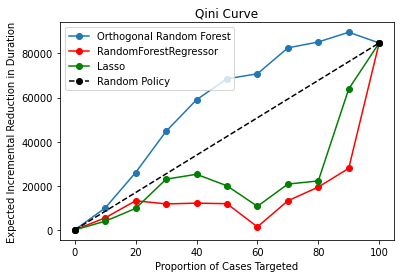

In [19]:
percentages = [10,20,30,40,50,60,70,80,90,100]

pred = Lasso()
pred.fit(X,Y)

pred2 = RandomForestRegressor()
pred2.fit(X,Y)

yhat_test = pred.predict(X_test)
print('MAE of test:', mean_absolute_error(test[outcome], yhat_test))
df_results['predictions_lasso'] = yhat_test

yhat_test2 = pred2.predict(X_test)
print('MAE of test:', mean_absolute_error(test[outcome], yhat_test2))
df_results['predictions_RF'] = yhat_test2

net_value = [0]
net_value2 = [0]
net_value3 = [0]
for n in percentages:
    num = int(len(df_results)*(n/100))
    top_n = df_results.nsmallest(num,'Treatment Effects')
    n_treated = top_n[top_n['treatment']==1].shape[0]
    n_control = top_n[top_n['treatment']==0].shape[0]
    scale_factor = n_treated/n_control

    treated = top_n[top_n['treatment']==1]['duration'].sum()
    control = top_n[top_n['treatment']==0]['duration'].sum()

    reduction = (scale_factor*control) - treated 
    net_value.append(reduction)
    
for n in percentages:
    num = int(len(df_results)*(n/100))
    top_n = df_results.nsmallest(num,'predictions_lasso')
    n_treated = top_n[top_n['treatment']==1].shape[0]
    n_control = top_n[top_n['treatment']==0].shape[0]
    scale_factor = n_treated/n_control

    treated = top_n[top_n['treatment']==1]['duration'].sum()
    control = top_n[top_n['treatment']==0]['duration'].sum()

    reduction = (scale_factor*control) - treated 
    net_value2.append(reduction)
    
for n in percentages:
    num = int(len(df_results)*(n/100))
    top_n = df_results.nsmallest(num,'predictions_RF')
    n_treated = top_n[top_n['treatment']==1].shape[0]
    n_control = top_n[top_n['treatment']==0].shape[0]
    scale_factor = n_treated/n_control

    treated = top_n[top_n['treatment']==1]['duration'].sum()
    control = top_n[top_n['treatment']==0]['duration'].sum()

    reduction = (scale_factor*control) - treated 
    net_value3.append(reduction)
#     net_value.append(reduction)

#normed = norm = [(float(i)-min(net_value))/(max(net_value)-min(net_value)) for i in net_value]


# plt.figure(figsize=(10, 4))
# plt.subplot(1, 2, 1)
plt.plot([0]+percentages, net_value, label="Orthogonal Random Forest", marker="o")
plt.plot([0]+percentages, net_value3, label="RandomForestRegressor", marker="o", color='Red')
plt.plot([0]+percentages, net_value2, label="Lasso", marker="o", color='Green')
plt.plot([0,percentages[9]], [0,net_value[10]], label="Random Policy",  marker="o", color='Black',
         linestyle='dashed')
plt.xlabel('Proportion of Cases Targeted')
plt.ylabel('Expected Incremental Reduction in Duration')
plt.legend(loc='best')
plt.title('Qini Curve')

plt.savefig('gdrive/My Drive/Results/Qini_curve_BPIC19_withBaseline-1.png', format='png', dpi=300)

MAE of test: 129.8847842141311
MAE of test: 126.97552388687939
Net value ORF: [0, 9960.489205816557, 26026.49970619657, 44716.01534114912, 59018.0057733782, 68536.46813107868, 70792.53628590325, 82538.70453732109, 85228.79765735686, 89636.5741011056, 84776.64710530557]

Net value Lasso: [0, 3957.4825571895417, 9760.55871559633, 23013.576295405976, 25228.66793394777, 19996.506719977537, 10707.207817910006, 20773.380336345377, 22218.790798611066, 63901.05886015319, 84776.64710530557]

Net value RF: [0, 6746.561527777772, 11847.975225225215, 15294.37269736841, 17126.423296645677, 10407.472407407433, -1172.557029872114, 3122.36094017094, 16286.909650267713, 26385.560363872617, 84776.64710530557]



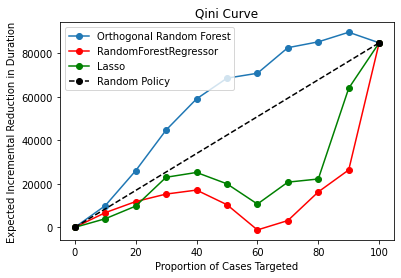

In [20]:
percentages = [10,20,30,40,50,60,70,80,90,100]

pred = Lasso()
pred.fit(X,Y)

pred2 = RandomForestRegressor()
pred2.fit(X,Y)

yhat_test = pred.predict(X_test)
print('MAE of test:', mean_absolute_error(test[outcome], yhat_test))
df_results['predictions_lasso'] = yhat_test

yhat_test2 = pred2.predict(X_test)
print('MAE of test:', mean_absolute_error(test[outcome], yhat_test2))
df_results['predictions_RF'] = yhat_test2

net_value = [0]
net_value2 = [0]
net_value3 = [0]
for n in percentages:
    num = int(len(df_results)*(n/100))
    top_n = df_results.nsmallest(num,'Treatment Effects')
    n_treated = top_n[top_n['treatment']==1].shape[0]
    n_control = top_n[top_n['treatment']==0].shape[0]
    scale_factor = n_treated/n_control

    treated = top_n[top_n['treatment']==1]['duration'].sum()
    control = top_n[top_n['treatment']==0]['duration'].sum()

    reduction = (scale_factor*control) - treated 
    net_value.append(reduction)
    
for n in percentages:
    num = int(len(df_results)*(n/100))
    top_n = df_results.nsmallest(num,'predictions_lasso')
    n_treated = top_n[top_n['treatment']==1].shape[0]
    n_control = top_n[top_n['treatment']==0].shape[0]
    scale_factor = n_treated/n_control

    treated = top_n[top_n['treatment']==1]['duration'].sum()
    control = top_n[top_n['treatment']==0]['duration'].sum()

    reduction = (scale_factor*control) - treated 
    net_value2.append(reduction)
    
for n in percentages:
    num = int(len(df_results)*(n/100))
    top_n = df_results.nsmallest(num,'predictions_RF')
    n_treated = top_n[top_n['treatment']==1].shape[0]
    n_control = top_n[top_n['treatment']==0].shape[0]
    scale_factor = n_treated/n_control

    treated = top_n[top_n['treatment']==1]['duration'].sum()
    control = top_n[top_n['treatment']==0]['duration'].sum()

    reduction = (scale_factor*control) - treated 
    net_value3.append(reduction)
#     net_value.append(reduction)

#normed = norm = [(float(i)-min(net_value))/(max(net_value)-min(net_value)) for i in net_value]


# plt.figure(figsize=(10, 4))
# plt.subplot(1, 2, 1)
plt.plot([0]+percentages, net_value, label="Orthogonal Random Forest", marker="o")
plt.plot([0]+percentages, net_value3, label="RandomForestRegressor", marker="o", color='Red')
plt.plot([0]+percentages, net_value2, label="Lasso", marker="o", color='Green')
plt.plot([0,percentages[9]], [0,net_value[10]], label="Random Policy",  marker="o", color='Black',
         linestyle='dashed')
plt.xlabel('Proportion of Cases Targeted')
plt.ylabel('Expected Incremental Reduction in Duration')
plt.legend(loc='best')
plt.title('Qini Curve')

plt.savefig('gdrive/My Drive/Results/Qini_curve_BPIC19_withBaseline-2.png', format='png', dpi=300)
print(f"Net value ORF: {net_value}\n")
print(f"Net value Lasso: {net_value2}\n")
print(f"Net value RF: {net_value3}\n")

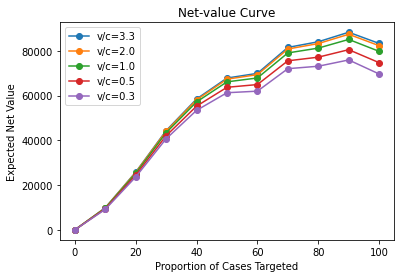

In [21]:
# net value curves
value = [1]
cost = [0.3,0.5,1,2,3]

percentages = [10,20,30,40,50,60,70,80,90,100]

for i in itertools.product(value, cost):
    v = i[0]
    c = i[1]
    net_value = [0]
    for n in percentages:
        num = int(len(df_results)*(n/100))
        top_n = df_results.nsmallest(num,'Treatment Effects')
        n_treated = top_n[top_n['treatment']==1].shape[0]
        n_control = top_n[top_n['treatment']==0].shape[0]
        scale_factor = n_treated/n_control

        treated = top_n[top_n['treatment']==1]['duration'].sum()
        control = top_n[top_n['treatment']==0]['duration'].sum()

        reduction = (scale_factor*control) - treated
        net_val = (reduction*v) - (3*n_treated*c)
#         print(net_val)
        net_value.append(net_val)
    #     net_value.append(reduction)

    #normed = norm = [(float(i)-min(net_value))/(max(net_value)-min(net_value)) for i in net_value]


    # plt.figure(figsize=(10, 4))
    # plt.subplot(1, 2, 1)
    plt.plot([0]+percentages, net_value, label="v/c=%s"%str(round(v/c,1)), marker="o")
    #     plt.plot([0]+percentages, net_value2, label="TE Lower bound", marker="o", color='Green')
    #     plt.plot([0]+percentages, net_value3, label="TE Upper bound", marker="o", color='Red')
#     plt.plot([0,percentages[9]], [0,net_value[10]], label="Random Policy",  marker="o", color='Black',
#              linestyle='dashed')
    plt.xlabel('Proportion of Cases Targeted')
    plt.ylabel('Expected Net Value')
    plt.legend(loc='best')
    plt.title('Net-value Curve')

plt.savefig('gdrive/My Drive/Results/NetVal_curve_BPIC19-1.png', format='png', dpi=300)

Net values (1, 0.3): [0, 9881.289205816556, 25787.099706196568, 44312.81534114912, 58453.7057733782, 67808.36813107868, 69908.73628590324, 81483.90453732108, 84014.69765735685, 88262.27410110559, 83261.04710530557]
Net values (1, 0.5): [0, 9828.489205816557, 25627.49970619657, 44044.01534114912, 58077.5057733782, 67322.96813107868, 69319.53628590325, 80780.70453732109, 83205.29765735686, 87346.0741011056, 82250.64710530557]
Net values (1, 1): [0, 9696.489205816557, 25228.49970619657, 43372.01534114912, 57137.0057733782, 66109.46813107868, 67846.53628590325, 79022.70453732109, 81181.79765735686, 85055.5741011056, 79724.64710530557]
Net values (1, 2): [0, 9432.489205816557, 24430.49970619657, 42028.01534114912, 55256.0057733782, 63682.468131078684, 64900.53628590325, 75506.70453732109, 77134.79765735686, 80474.5741011056, 74672.64710530557]
Net values (1, 3): [0, 9168.489205816557, 23632.49970619657, 40684.01534114912, 53375.0057733782, 61255.468131078684, 61954.53628590325, 71990.704537

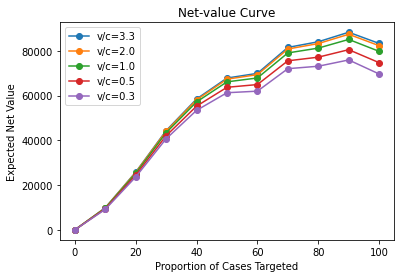

In [22]:
# net value curves
value = [1]
cost = [0.3,0.5,1,2,3]

percentages = [10,20,30,40,50,60,70,80,90,100]

for i in itertools.product(value, cost):
    v = i[0]
    c = i[1]
    net_value = [0]
    for n in percentages:
        num = int(len(df_results)*(n/100))
        top_n = df_results.nsmallest(num,'Treatment Effects')
        n_treated = top_n[top_n['treatment']==1].shape[0]
        n_control = top_n[top_n['treatment']==0].shape[0]
        scale_factor = n_treated/n_control

        treated = top_n[top_n['treatment']==1]['duration'].sum()
        control = top_n[top_n['treatment']==0]['duration'].sum()

        reduction = (scale_factor*control) - treated
        net_val = (reduction*v) - (3*n_treated*c)
#         print(net_val)
        net_value.append(net_val)
    #     net_value.append(reduction)

    #normed = norm = [(float(i)-min(net_value))/(max(net_value)-min(net_value)) for i in net_value]
    print(f"Net values {i}: {net_value}")

    # plt.figure(figsize=(10, 4))
    # plt.subplot(1, 2, 1)
    plt.plot([0]+percentages, net_value, label="v/c=%s"%str(round(v/c,1)), marker="o")
    #     plt.plot([0]+percentages, net_value2, label="TE Lower bound", marker="o", color='Green')
    #     plt.plot([0]+percentages, net_value3, label="TE Upper bound", marker="o", color='Red')
#     plt.plot([0,percentages[9]], [0,net_value[10]], label="Random Policy",  marker="o", color='Black',
#              linestyle='dashed')
    plt.xlabel('Proportion of Cases Targeted')
    plt.ylabel('Expected Net Value')
    plt.legend(loc='best')
    plt.title('Net-value Curve')

plt.savefig('gdrive/My Drive/Results/NetVal_curve_BPIC19-2.png', format='png', dpi=300)
